In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the Libraries

In [2]:
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Importing the Data

In [3]:
df = pd.read_csv('Electric_Production.csv')
df.rename(columns={'DATE':'date','IPG2211A2N':'production'},inplace=True)

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.columns

Index(['date', 'production'], dtype='object')

In [6]:
df.describe()

,date,production
count,397,397.000000
mean,2001-07-01 13:25:14.357682560,88.847218
min,1985-01-01 00:00:00,55.315100
25%,1993-04-01 00:00:00,77.105200
50%,2001-07-01 00:00:00,89.779500
75%,2009-10-01 00:00:00,100.524400
max,2018-01-01 00:00:00,129.404800
std,NaN,15.387834


# Non-Stationarity to Stationarity

<Axes: xlabel='date', ylabel='production'>

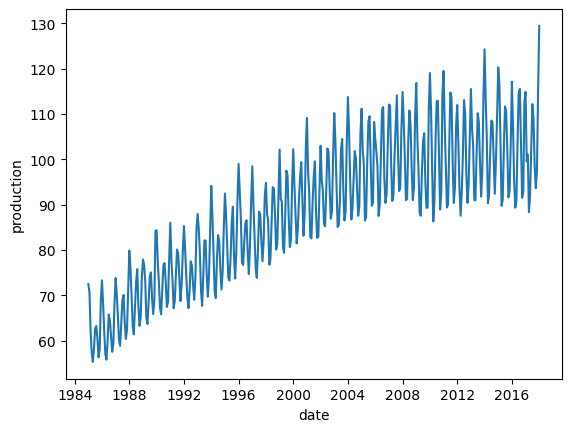

In [7]:
# Describe the time series data
sns.lineplot(data=df,x='date',y='production')

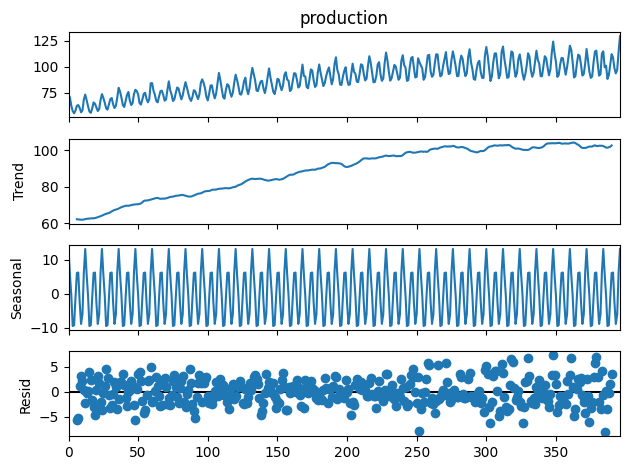

In [8]:
# Decomposing the data for better view of the data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(x=df['production'],model='additive',period=12)
decomposition.plot()
plt.show()

In [9]:
#Augumented Dicky Fuller(ADF) test for stationarity
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['production'],autolag='AIC')
adf,p_value,_,_,_,_ = adfuller(df['production'])
print(f'ADF: {round(adf,2)}')
print(f'p_value: {round(p_value,2)}')
threshold = 0.05
if p_value<threshold:
    print('The data is stationary')
else:
    print('The data is not stationary')

ADF: -2.26
p_value: 0.19
The data is not stationary


<function matplotlib.pyplot.show(close=None, block=None)>

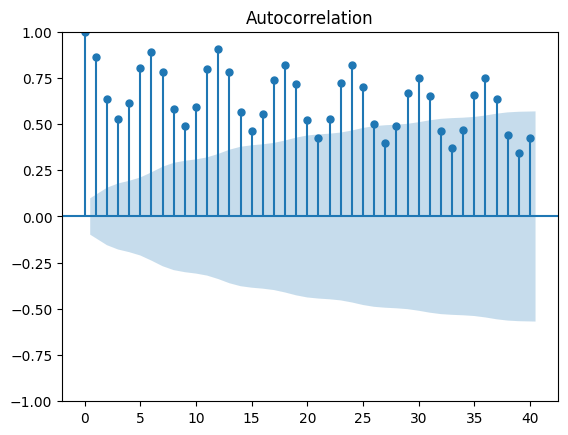

In [10]:
#Checking the data visually with lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['production'],lags=40)
plt.show

In [11]:
#Converting non stationay data into stationay data using $Differencing$
#Trend removal
diff = df['production']-df['production'].shift(1)
diff = diff.dropna(inplace = False)

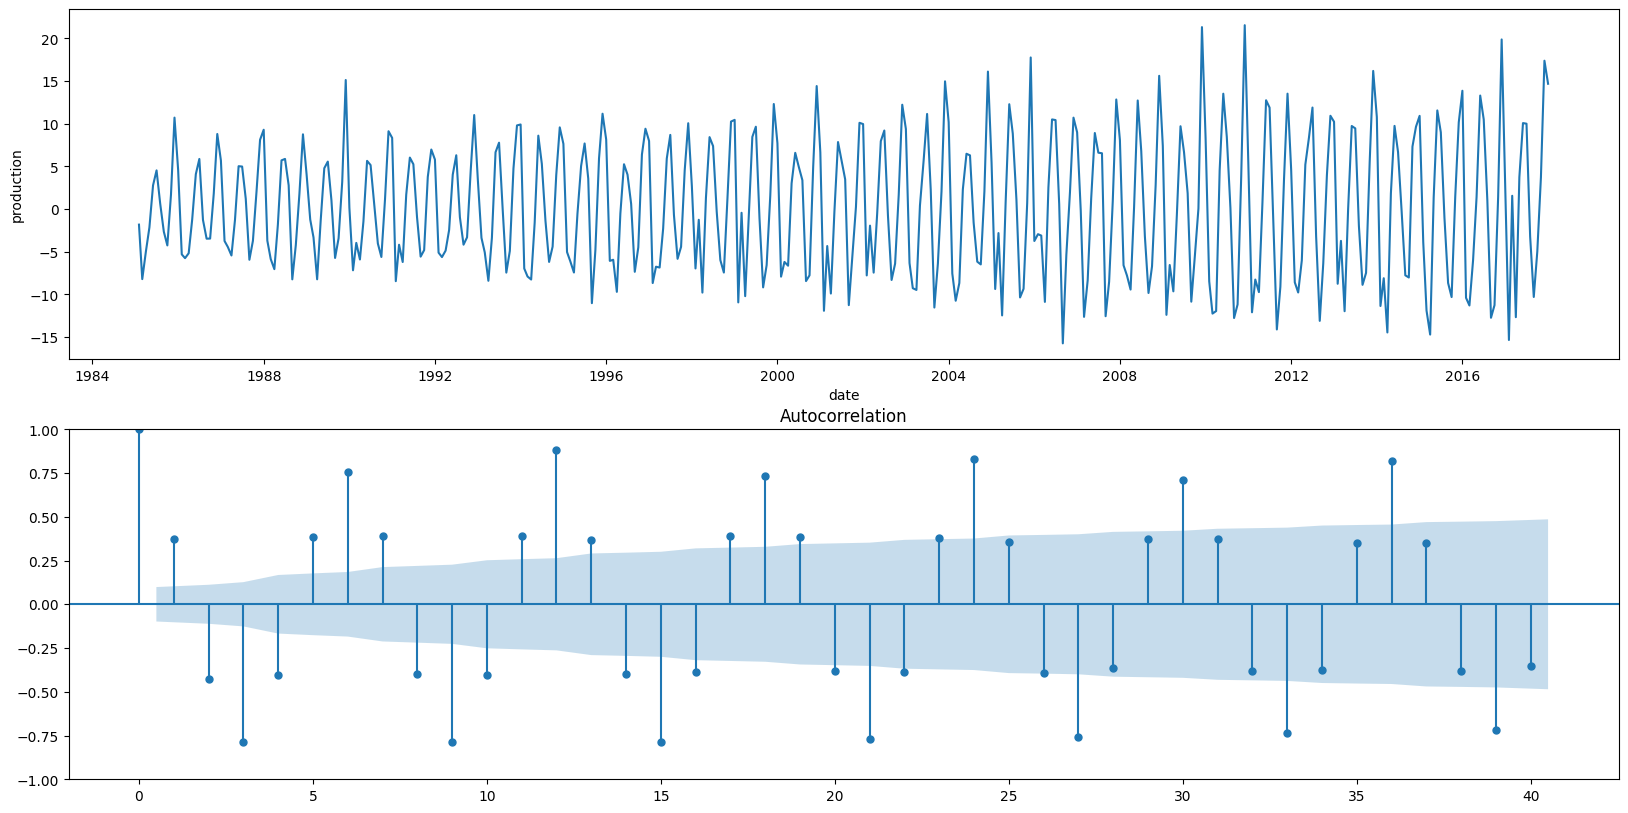

In [12]:
#ACF after trend removal
fig = plt.figure(figsize=(20, 10))
subplot1 = fig.add_subplot(211)
subplot2 = fig.add_subplot(212)
sns.lineplot(x=df['date'],y=diff,ax=subplot1)
plot_acf(diff,lags=40,ax=subplot2)
plt.show()

In [13]:
#Seasonality Removal
diff = df['production']-df['production'].shift(1)
diff_season = diff - diff.shift(12)
diff_season = diff_season.dropna(inplace=False)

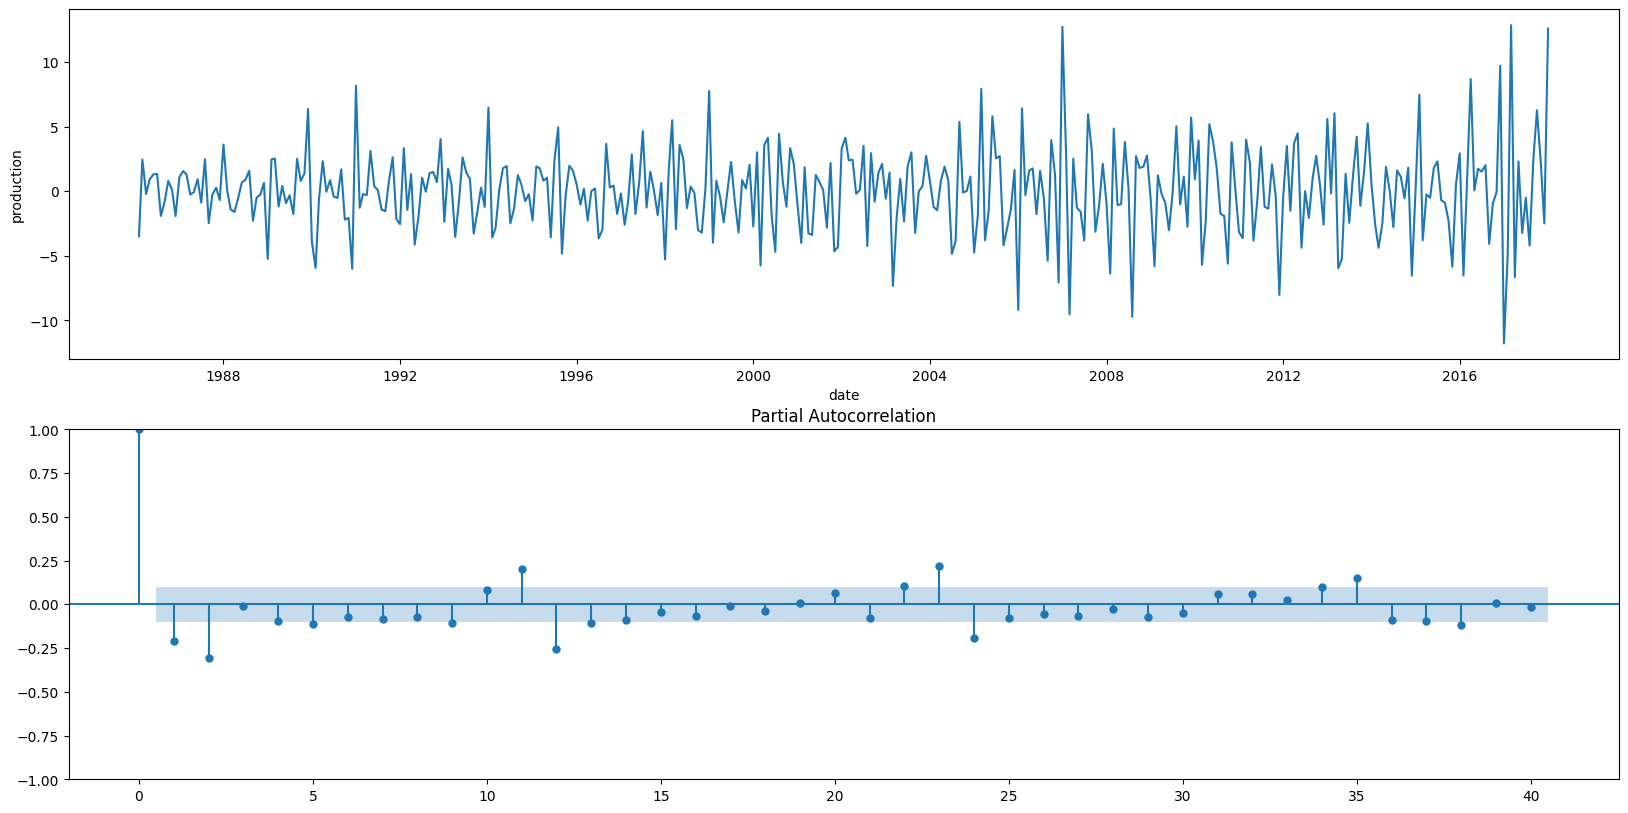

In [14]:
#PACF after Seasonality removal
fig = plt.figure(figsize=(20, 10))
subplot1 = fig.add_subplot(211)
subplot2 = fig.add_subplot(212)
sns.lineplot(x=df['date'],y=diff_season,ax=subplot1)
plot_pacf(diff_season,lags=40,ax=subplot2)
plt.show()

In [15]:
#Augumented Dicky Fuller(ADF) test for stationarity after data tranformation
dftest = adfuller(diff_season,autolag='AIC')
adf,p_value,_,_,_,_ = adfuller(diff_season)
print(f'ADF: {round(adf,2)}')
print(f'p_value: {round(p_value,2)}')
threshold = 0.05
if p_value<threshold:
    print('The data is stationary')
else:
    print('The data is not stationary')

ADF: -8.02
p_value: 0.0
The data is stationary


# Split the time series data into test and train data

In [16]:
df_test = df[['date', 'production']].loc[300:]
df_train = df[['date', 'production']].loc[:299]

# ARMA

In [17]:
#ARMA(p,q)
#AR -> p -> PACF -> 3
#MA -> q -> ACF -> 4
from statsmodels.tsa.arima.model import ARIMA
ARMA_model = ARIMA(df_train['production'],order=(3,0,4)).fit(method_kwargs={"warn_convergence": False})

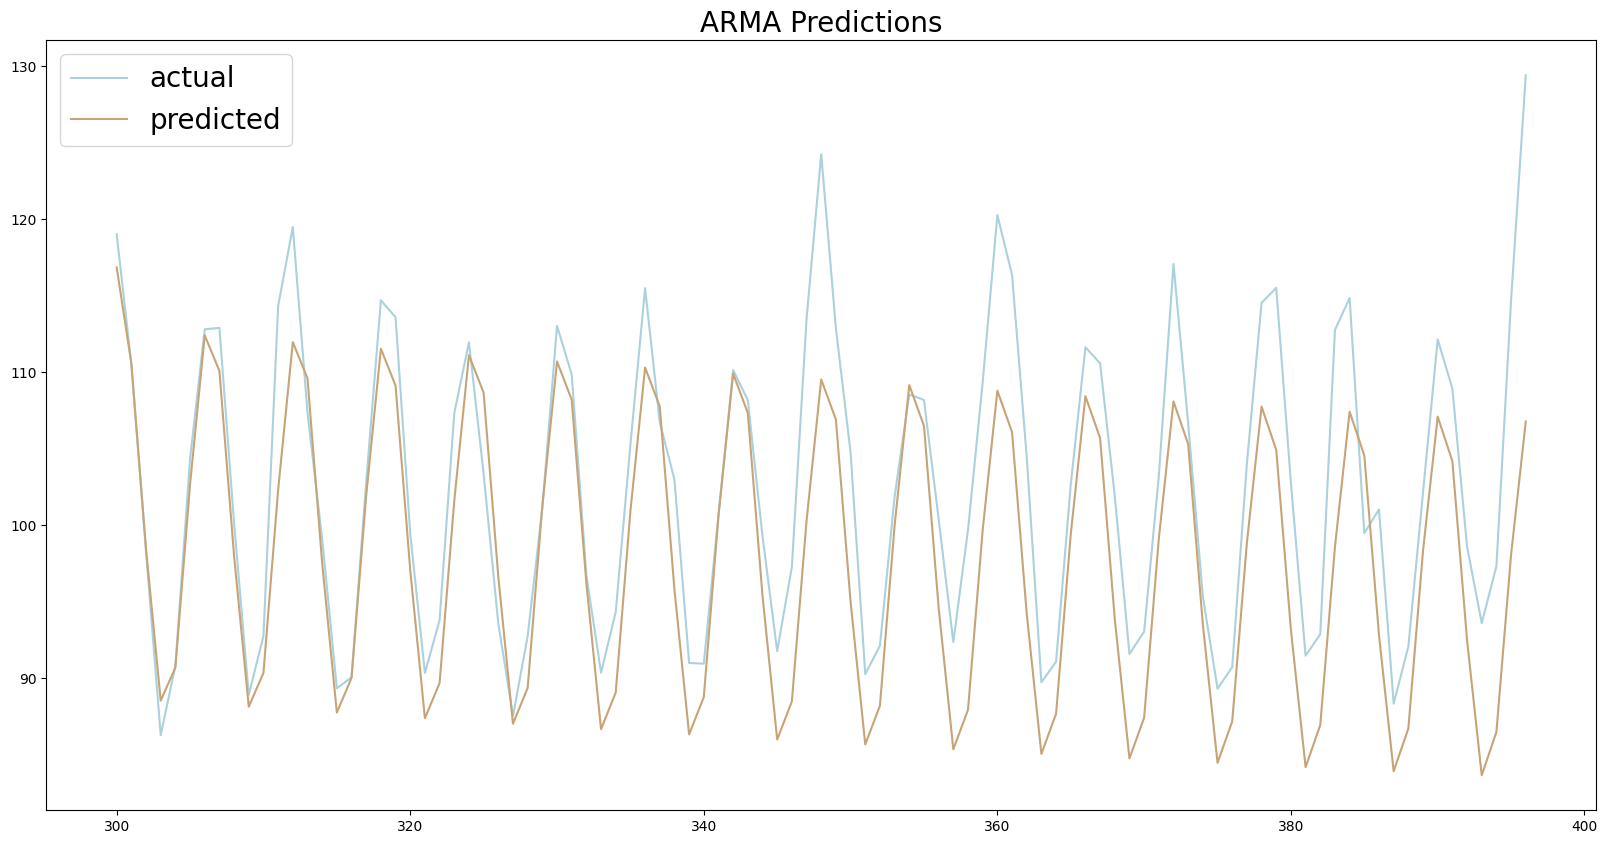

In [18]:
# generate predictions
df_pred = ARMA_model.predict(start=300, end=396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=20)
plt.plot(df_test['production'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [19]:
rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))
print('Larger RMSE indicates more difference between actual and predicted values.')

RMSE: 6.53
Larger RMSE indicates more difference between actual and predicted values.


In [20]:
ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  300
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -764.567
Date:                Sat, 19 Oct 2024   AIC                           1547.133
Time:                        16:33:23   BIC                           1580.468
Sample:                             0   HQIC                          1560.474
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.3304      7.841     10.755      0.000      68.963      99.698
ar.L1          1.9938      0.005    402.485      0.000       1.984       2.003
ar.L2         -1.9926      0.006   -338.988      0.000      -2.004      -1.981
ar.L3          0.9944      0.004    222.046      0.000       0.986       1.003
ma.L1         -1.2866      0.112    -11.454      0.000      -1.507      -1.066
ma.L2          0.9609      0.279      3.438      0.001       0.413       1.509
ma.L3         -0.0125      0.097     -0.129      0.897      -0.203       0.178
ma.L4         -0.3698      0.125     -2.960      0.003      -0.615      -0.125
sigma2         9.2019      2.335      3.941      0.000       4.626      13.778
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                15.75
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
print('Model to have less AIC,log likelihood needs to be high')

Model to have less AIC,log likelihood needs to be high


# ARIMA

In [22]:
#ARIMA(p,d,q) ---> Address Trend
#AR -> p -> PACF -> 3
#MA -> q -> ACF -> 4
#I  -> d -> ADF after detrending -> 1
from statsmodels.tsa.arima.model import ARIMA
ARIMA_model = ARIMA(df_train['production'],order=(3,1,4)).fit(method_kwargs={"warn_convergence": False})

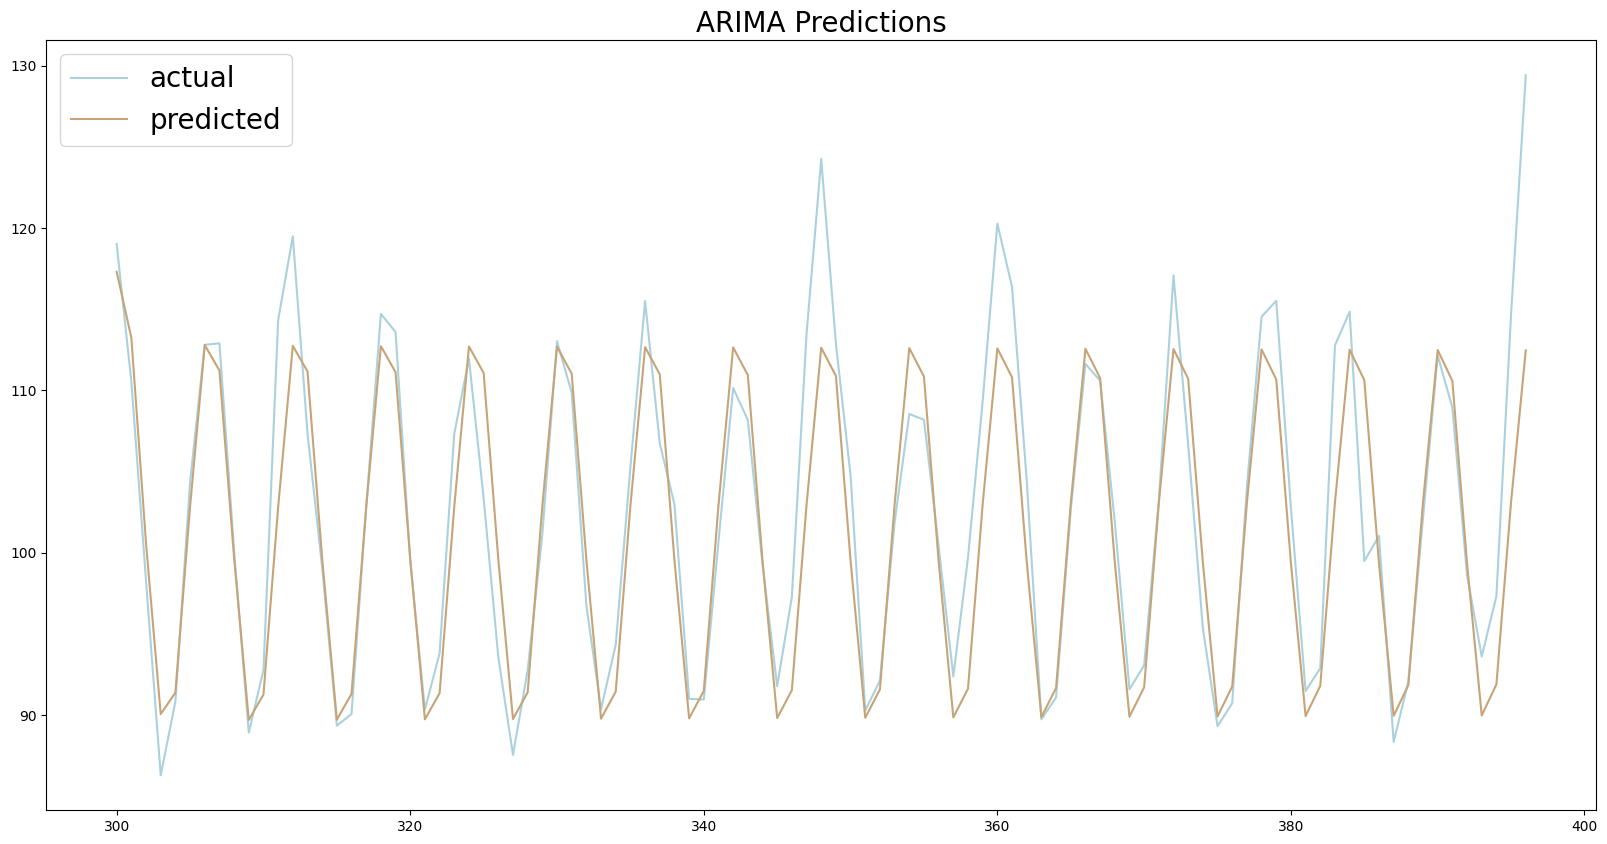

In [23]:
# generate predictions
df_pred = ARIMA_model.predict(start=300, end=396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARIMA Predictions', fontsize=20)
plt.plot(df_test['production'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [24]:
rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))
print('Larger RMSE indicates more difference between actual and predicted values.')

RMSE: 4.35
Larger RMSE indicates more difference between actual and predicted values.


In [25]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  300
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -756.424
Date:                Sat, 19 Oct 2024   AIC                           1528.847
Time:                        16:33:25   BIC                           1558.451
Sample:                             0   HQIC                          1540.696
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4374      0.165      8.702      0.000       1.114       1.761
ar.L2         -1.4371      0.165     -8.699      0.000      -1.761      -1.113
ar.L3          0.4382      0.165      2.655      0.008       0.115       0.762
ma.L1         -1.7119      0.170    -10.059      0.000      -2.045      -1.378
ma.L2          1.6213      0.299      5.422      0.000       1.035       2.207
ma.L3         -0.6720      0.263     -2.553      0.011      -1.188      -0.156
ma.L4         -0.1021      0.119     -0.855      0.393      -0.336       0.132
sigma2         8.8652      1.386      6.397      0.000       6.149      11.581
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                19.59
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMA

In [26]:
#SARIMAX(p,d,q)x(P,D,Q,s) ---> Address Seasonality
#AR -> p -> PACF -> 3
#MA -> q -> ACF -> 4
#I  -> d -> ADF after detrending -> 1
#AR(S) -> P -> 1
#MA(S) -> Q -> 1
#I(S) -> D -> 1
#s(S) -> s -> ACF after deseasoning -> 12
from statsmodels.tsa.statespace.sarimax import SARIMAX
SARIMA_model = SARIMAX(df_train['production'],order=(3,1,4),seasonal_order=(1, 1, 1, 12)).fit()

c:\Users\ruanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


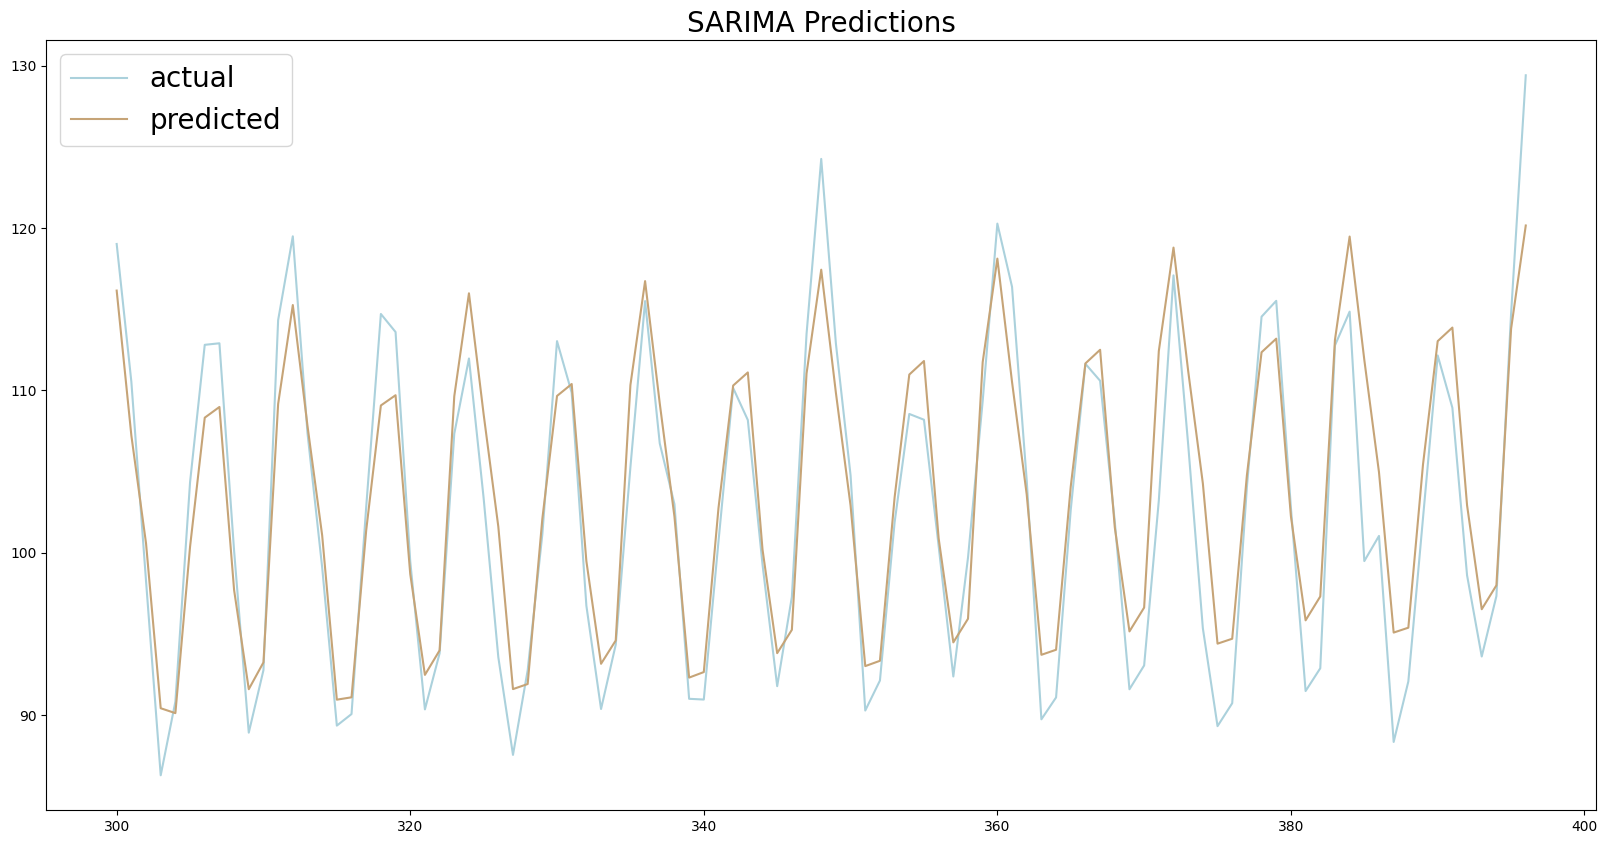

In [27]:
# generate predictions
df_pred = SARIMA_model.predict(start=300, end=396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('SARIMA Predictions', fontsize=20)
plt.plot(df_test['production'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [28]:
rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))

RMSE: 3.69


In [29]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  300
Model:             SARIMAX(3, 1, 4)x(1, 1, [1], 12)   Log Likelihood                -628.656
Date:                              Sat, 19 Oct 2024   AIC                           1277.313
Time:                                      16:33:36   BIC                           1313.908
Sample:                                           0   HQIC                          1291.979
                                              - 300                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1920      0.144      1.330      0.184      -0.091       0.475
ar.L2         -0.8428      0.063    -13.299      0.000      -0.967      -0.719
ar.L3          0.2617      0.140      1.873      0.061      -0.012       0.536
ma.L1         -0.6118      0.146     -4.179      0.000      -0.899      -0.325
ma.L2          0.6697      0.137      4.904      0.000       0.402       0.937
ma.L3         -0.6442      0.148     -4.338      0.000      -0.935      -0.353
ma.L4         -0.2492      0.124     -2.006      0.045      -0.493      -0.006
ar.S.L12       0.0658      0.097      0.676      0.499      -0.125       0.257
ma.S.L12      -0.7401      0.074     -9.955      0.000      -0.886      -0.594
sigma2         4.4961      0.330     13.626      0.000       3.849       5.143
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                52.12
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""